# Based
- https://www.kaggle.com/code/honganzhu/cmi-piu-competition?scriptVersionId=201912528 Version44 LB0.492

 If you find this notebook useful, please upvote this and the based one.

In [1]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from pytorch_tabnet.tab_model import TabNetRegressor
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

In [2]:
SEED = 42
n_splits = 5

# Feature Engineering

- **Feature Selection**: The dataset contains features related to physical characteristics (e.g., BMI, Height, Weight), behavioral aspects (e.g., internet usage), and fitness data (e.g., endurance time). 
- **Categorical Feature Encoding**: Categorical features are mapped to numerical values using custom mappings for each unique category within the dataset. This ensures compatibility with machine learning algorithms that require numerical input.
- **Time Series Aggregation**: Time series statistics (e.g., mean, standard deviation) from the actigraphy data are computed and merged into the main dataset to create additional features for model training.


In [3]:
def process_file(id_folder, dirname):
    files = os.listdir(os.path.join(path, dirname, id_folder))
    if len(files) > 1:
        df_list = []
        for file in files:
            df = pd.read_parquet(os.path.join(dirname, id_folder, file))
            df_list.append(df)
        df = pd.concat(df_list, ignore_index=True)
    else:
        df = pd.read_parquet(os.path.join(dirname, id_folder, files[0]))
    
    df.drop('step', axis=1, inplace=True)

    df = df[df['non-wear_flag'] == 0].drop('non-wear_flag', axis=1).reset_index(drop=True)

    describe_df = df.describe(percentiles=[0.01] + [i*0.5/10 + 0.05 for i in range(19)] + [0.99])
    count_mean = describe_df.loc['count', :].mean()
    describe_df.drop('count', axis=0, inplace=True)
    
    return np.append(describe_df.values.reshape(-1), count_mean), id_folder.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df


class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*4),
            nn.ReLU(),
            nn.Linear(encoding_dim*4, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim*4),
            nn.ReLU(),
            nn.Linear(encoding_dim*4, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled)
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

def feature_engineering(df):
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df

In [4]:
path = "I:/Kaggle/child-mind-institute-problematic-internet-use/"

In [5]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sample = pd.read_csv(path + 'sample_submission.csv')

In [6]:
def process_file(id_folder, dirname):
    files = os.listdir(os.path.join(path, dirname, id_folder))
    if len(files) > 1:
        df_list = []
        for file in files:
            df = pd.read_parquet(os.path.join(dirname, id_folder, file))
            df_list.append(df)
        df = pd.concat(df_list, ignore_index=True)
    else:
        df = pd.read_parquet(os.path.join(dirname, id_folder, files[0]))

    return df
    
    df.drop('step', axis=1, inplace=True)

    df = df[df['non-wear_flag'] == 0].drop('non-wear_flag', axis=1).reset_index(drop=True)

    describe_df = df.describe(percentiles=[0.01] + [i*0.5/10 + 0.05 for i in range(19)] + [0.99])
    count_mean = describe_df.loc['count', :].mean()
    describe_df.drop('count', axis=0, inplace=True)
    
    return np.append(describe_df.values.reshape(-1), count_mean), id_folder.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))

    return results
    
    stats, indexes = zip(*results)

    
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

In [7]:
test_ts_eda = load_time_series(path + "series_test.parquet")

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 48.55it/s]


In [8]:
len(test_ts_eda)

2

In [9]:
test_ts_eda[0].head()

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
0,0,0.021536,0.022214,-1.022370,0.022853,-88.280762,0.0,53.000000,4188.000000,56940000000000,4,3,41.0
1,1,0.022005,0.022187,-1.019740,0.020231,-88.241707,0.0,51.666668,4188.166504,56945000000000,4,3,41.0
2,2,0.022240,0.022005,-1.019401,0.019893,-88.170067,0.0,50.333332,4188.333496,56950000000000,4,3,41.0
3,3,0.021589,0.022578,-1.018177,0.018667,-88.250031,0.0,50.500000,4188.500000,56955000000000,4,3,41.0
4,4,0.022005,0.023763,-1.014323,0.016848,-88.130775,0.0,33.166668,4181.000000,57235000000000,4,3,41.0


In [10]:
test_ts_eda[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43330 entries, 0 to 43329
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   step                 43330 non-null  uint32 
 1   X                    43330 non-null  float32
 2   Y                    43330 non-null  float32
 3   Z                    43330 non-null  float32
 4   enmo                 43330 non-null  float32
 5   anglez               43330 non-null  float32
 6   non-wear_flag        43330 non-null  float32
 7   light                43330 non-null  float32
 8   battery_voltage      43330 non-null  float32
 9   time_of_day          43330 non-null  int64  
 10  weekday              43330 non-null  int8   
 11  quarter              43330 non-null  int8   
 12  relative_date_PCIAT  43330 non-null  float32
dtypes: float32(9), int64(1), int8(2), uint32(1)
memory usage: 2.1 MB


In [11]:
test_ts_eda[0].describe()

,step,X,Y,Z,enmo,anglez,non-wear_flag,light,battery_voltage,time_of_day,weekday,quarter,relative_date_PCIAT
count,43330.000000,43330.000000,43330.000000,43330.000000,43330.000000,43330.000000,43330.0,43330.000000,43330.000000,4.333000e+04,43330.000000,43330.0,43330.000000
mean,21664.500000,-0.316384,0.016009,-0.167890,0.047388,-10.580416,0.0,42.296310,4053.579102,5.046215e+13,4.470182,3.0,53.201683
std,12508.437919,0.453665,0.502702,0.585710,0.106351,42.947170,0.0,208.168976,112.404045,1.942842e+13,1.931421,0.0,14.244914
min,0.000000,-1.746094,-2.905339,-1.048372,0.000000,-89.833092,0.0,0.000000,3824.000000,5.500000e+10,1.000000,3.0,41.000000
25%,10832.250000,-0.684180,-0.309863,-0.649974,0.006432,-41.541863,0.0,2.392969,4028.666748,3.689000e+13,3.000000,3.0,42.000000
50%,21664.500000,-0.366849,0.024974,-0.245378,0.023637,-15.086617,0.0,6.926828,4070.000000,5.347750e+13,5.000000,3.0,50.000000
75%,32496.750000,-0.010677,0.400677,0.204727,0.041420,12.220764,0.0,15.000000,4147.000000,6.640875e+13,6.000000,3.0,53.000000
max,43329.000000,1.507865,1.666354,1.546979,4.004276,89.751656,0.0,2633.250000,4188.500000,8.611000e+13,7.000000,3.0,85.000000


In [12]:
test_ts_eda[0]['time_of_day'][0] / 86400e9

0.6590277777777778

<Axes: xlabel='time_of_day', ylabel='Count'>

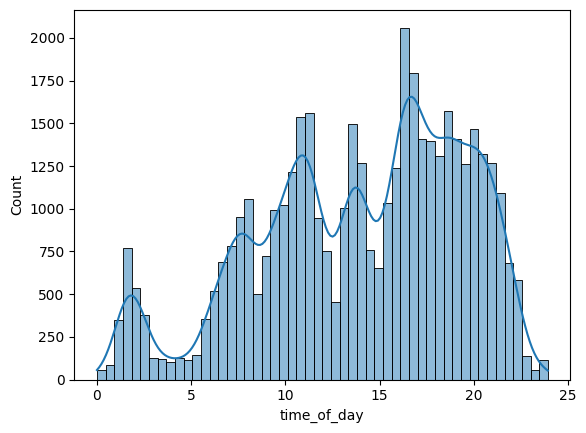

In [13]:
sns.histplot(test_ts_eda[0]['time_of_day'].apply(lambda x: x / 3600e9), kde=True)

In [14]:
test_ts_eda[0]['weekday'].value_counts()

weekday
5    10223
7     8566
4     6545
6     5307
1     4780
3     3996
2     3913
Name: count, dtype: int64

<Axes: xlabel='weekday', ylabel='Count'>

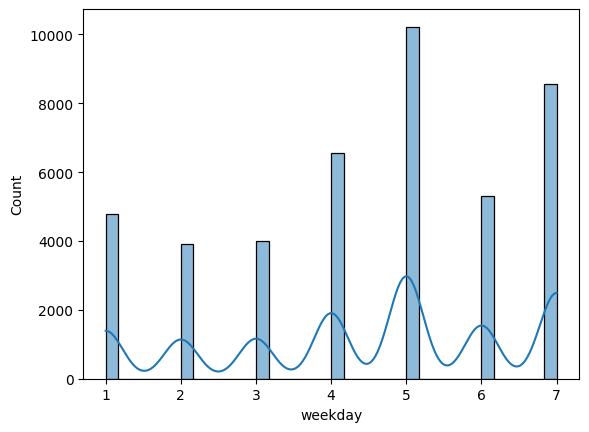

In [16]:
sns.histplot(test_ts_eda[0]['weekday'], kde=True)

In [17]:
os.listdir()

['.ipynb_checkpoints',
 'best_tabnet_model.pt.zip',
 'catboost_info',
 'childmind_eda_20241122.ipynb',
 'childmind_eda_20241123.ipynb',
 'childmind_eda_20241129.ipynb',
 'lb0-494-with-tabnet - Practice.ipynb',
 'lb0-494-with-tabnet-autoencoder-data-edited.ipynb',
 'lb0-494-with-tabnet-baseline-training-20241129_01.ipynb',
 'lb0-494-with-tabnet-baseline-training-20241129_02.ipynb',
 'lb0-494-with-tabnet-baseline-training-20241129_03.ipynb',
 'lb0-494-with-tabnet-baseline-training-20241130_01.ipynb',
 'lb0-494-with-tabnet-baseline-training-20241130_02.ipynb',
 'lb0-494-with-tabnet-baseline-training-20241201_01.ipynb',
 'lb0-494-with-tabnet-baseline-training-20241201_02.ipynb',
 'lb0-494-with-tabnet-baseline-training-20241201_03.ipynb',
 'lb0-494-with-tabnet-baseline-training.ipynb',
 'lb0-494-with-tabnet-baseline.ipynb',
 'lb0-494-with-tabnet.ipynb']

In [ ]:
train_ts = load_time_series(path + "series_train.parquet")
test_ts = load_time_series(path + "series_test.parquet")

In [ ]:
concat_ts = pd.concat([train_ts, test_ts], ignore_index=True)
df_concat = concat_ts.drop('id', axis=1)

In [ ]:
for col in df_concat.columns:
    if df_concat[col].std() == 0:
        df_concat.drop(col, axis=1, inplace=True)

In [ ]:
time_series_cols = df_concat.columns.tolist()
df_concat["id"] = concat_ts["id"]
train_ts = df_concat.head(train_ts.shape[0]).reset_index(drop=True)
test_ts = df_concat.tail(test_ts.shape[0]).reset_index(drop=True)
train_merge = pd.merge(train, train_ts, how="left", on='id')
test_merge = pd.merge(test, test_ts, how="left", on='id')

In [ ]:
data_dict = pd.read_csv(path + 'data_dictionary.csv')
print(data_dict.shape)
data_dict

In [ ]:
cat_cols = []
for i in range(data_dict.shape[0]):
    col = data_dict['Field'][i]
    if col == 'id':
        continue
    if (data_dict['Type'][i] == 'str') | ('categori' in data_dict['Type'][i]):
        cat_cols.append(col)

In [ ]:
ordinal_variables = ['FGC-FGC_CU_Zone', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone',
                     'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num',
                     'PreInt_EduHx-computerinternet_hoursday']

ordinal_variables += [col for col in cat_cols if (('PCIAT' in col)&('Season' not in col))]
print(len(ordinal_variables))
ordinal_variables

In [ ]:
cat_cols = list(set(cat_cols) - set(ordinal_variables))
print(len(cat_cols))
cat_cols

In [ ]:
train_nonan = train_merge.dropna(subset=['sii'], ignore_index=True)
print(train_nonan.shape)
train_nonan.head()

In [ ]:
train_one_hot = train_nonan.copy()
test_one_hot = test_merge.copy()

In [ ]:
for col in cat_cols:
    if 'PCIAT' not in col:
        train_sr = train_one_hot[col].fillna('Missing').apply(str)        
        test_sr = test_one_hot[col].fillna('Missing').apply(str)
        train_one_hot[col] = train_sr
        test_one_hot[col] = test_sr
        concat_sr = pd.concat([train_sr, test_sr])
        unique_list = sorted(concat_sr.unique().tolist())

        for v in unique_list:
            new_col_name = col + '_' + v
            train_one_hot[new_col_name] = pd.Series(train_one_hot[col] == v).astype(int)
            test_one_hot[new_col_name] = pd.Series(test_one_hot[col] == v).astype(int)
    else:
        train_sr = train_one_hot[col].fillna('Missing').apply(str)
        train_one_hot[col] = train_sr
        unique_list = sorted(train_sr.unique().tolist())

        for v in unique_list:
            new_col_name = col + '_' + v
            train_one_hot[new_col_name] = pd.Series(train_one_hot[col] == v).astype(int)

train_one_hot.drop(cat_cols, axis=1, inplace=True)
test_one_hot.drop([col for col in cat_cols if 'PCIAT' not in col], axis=1, inplace=True)

In [ ]:
print(train_ts.shape)
train_ts.head()

In [ ]:
print(train_one_hot.shape)
train_one_hot.head()

In [ ]:
print(test_one_hot.shape)
test_one_hot.head()

In [ ]:
train_one_hot.drop('id', axis=1, inplace=True)
test_one_hot.drop('id', axis=1, inplace=True)

In [ ]:
train = train_one_hot[test_one_hot.columns.tolist() + ['sii']].copy()
test = test_one_hot.copy()

In [ ]:
print(train.shape)
train.head()

In [ ]:
print(test.shape)
test.head()

In [ ]:
concat_df = pd.concat([train[test.columns], test], ignore_index=True)
print(concat_df.shape)
concat_df.head()

In [ ]:
imputer = KNNImputer(n_neighbors=5)
imputed_data_concat = imputer.fit_transform(concat_df)

In [ ]:
concat_imputed = pd.DataFrame(imputed_data_concat, columns=concat_df.columns)
print(concat_imputed.shape)
concat_imputed.head()

In [ ]:
concat_imputed.isna().sum().sum()

In [ ]:
concat_imputed = feature_engineering(concat_imputed)
print(concat_imputed.shape)
concat_imputed.head()

In [ ]:
if np.any(np.isinf(concat_imputed)):
    print('inf in data')
    concat_imputed = concat_imputed.replace([np.inf, -np.inf], np.nan)

In [ ]:
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(concat_imputed)

In [ ]:
concat_imputed = pd.DataFrame(imputed_data, columns=concat_imputed.columns)
print(concat_imputed.shape)
concat_imputed.head()

In [ ]:
concat_imputed.isna().sum().sum()

In [ ]:
train_imputed = concat_imputed.head(train.shape[0]).reset_index(drop=True)
test_imputed = concat_imputed.tail(test.shape[0]).reset_index(drop=True)

In [ ]:
train_imputed['sii'] = train['sii']

In [ ]:
train_final = train_imputed.copy()
test_final = test_imputed.copy()

In [ ]:
print(train_final.shape)
print(test_final.shape)

In [ ]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

# Model Training and Evaluation

- **Model Types**: Various models are used, including:
  - **LightGBM**: A gradient-boosting framework known for its speed and efficiency with large datasets.
  - **XGBoost**: Another powerful gradient-boosting model used for structured data.
  - **CatBoost**: Optimized for categorical features without the need for extensive preprocessing.
  - **Voting Regressor**: An ensemble model that combines the predictions of LightGBM, XGBoost, and CatBoost for better accuracy.
- **Cross-Validation**: Stratified K-Folds cross-validation is employed to split the data into training and validation sets, ensuring balanced class distribution in each fold.
- **Quadratic Weighted Kappa (QWK)**: The performance of the models is evaluated using QWK, which measures the agreement between predicted and actual values, taking into account the ordinal nature of the target variable.
- **Threshold Optimization**: The `minimize` function from `scipy.optimize` is used to fine-tune decision thresholds that map continuous predictions to discrete categories (None, Mild, Moderate, Severe).


In [ ]:
def TrainML(model_class, train_data, test_data):
    X = train_data.drop(['sii'], axis=1)
    y = train_data['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission


# Hyperparameter Tuning

- **LightGBM Parameters**: Hyperparameters such as `learning_rate`, `max_depth`, `num_leaves`, and `feature_fraction` are tuned to improve the performance of the LightGBM model. These parameters control the complexity of the model and its ability to generalize to new data.
- **XGBoost and CatBoost Parameters**: Similar tuning is applied for XGBoost and CatBoost, adjusting parameters such as `n_estimators`, `max_depth`, `learning_rate`, `subsample`, and `regularization` terms (`reg_alpha`, `reg_lambda`). These help in controlling overfitting and ensuring the model's robustness.

In [ ]:
Params7 = {
    'learning_rate': 0.03884249148676395,
    'max_depth': 12,
    'num_leaves': 413,
    'min_data_in_leaf': 14,
    'feature_fraction': 0.7987976913702801,
    'bagging_fraction': 0.7602261703576205,
    'bagging_freq': 2,
    'lambda_l1': 4.735462555910575,
    'lambda_l2': 4.735028557007343e-06
} # CV : 0.4094 | LB : 0.471

In [ ]:
Light = LGBMRegressor(**Params7, random_state=SEED, verbose=-1, n_estimators=200)

In [ ]:
Submission1 = TrainML(Light, train_final, test_final)
Submission1.to_csv('submission.csv', index=False)

Submission1